In [1]:
import numpy as np
import pandas as pd
from glob import glob as glob

In [2]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer, QuantileTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('notebook')

# 1. Data Preparation

In [4]:
# Load target values and corresponding scaler
targets = pd.read_csv('datasets/targets.csv')
targets = targets.rename(columns={'Unnamed: 0': 'Id'}).set_index('Id')
feature_transform = True

import joblib
scaler_targets = joblib.load('datasets/targets_scaler.pkl')

In [5]:
# Extract ID for train and test set
train_id = targets.index.values
sample_submission = pd.read_csv('sample_submission.csv')
test_id = np.unique(sample_submission.Id.str.split('_', expand=True)[0].astype('int'))

# 2. Modeling

In [6]:
def load_dataset(dataset_id, target):

    # Load dataset
    X_tr = pd.read_csv('datasets/%s_train.csv' % dataset_id)
    X_te = pd.read_csv('datasets/%s_test.csv' % dataset_id)

    # Specify target
    y = pd.read_csv('datasets/targets.csv')
    y = y.rename(columns={'Unnamed: 0': 'Id'}).set_index('Id')
    y_tr = y.iloc[X_tr.index][target]

    # Remove missing values
    missval = y_tr.isnull().values
    idx = ~missval
    X_tr = X_tr[idx]
    y_tr = y_tr[idx]
    print('Removing %s missing values from target dataset.' % missval.sum())
    
    return X_tr, X_te, y_tr, idx

In [7]:
# Create scorer function
from sklearn.metrics import make_scorer
def model_metric(y_true, y_pred, scaler=None, tidx=0):
    t_true = scaler.inverse_transform(np.transpose([y_true] * 5))[:, tidx]
    t_pred = scaler.inverse_transform(np.transpose([y_pred] * 5))[:, tidx]
    if tidx > 0:
        t_true = np.power(t_true, 1./1.5)
        t_pred = np.power(t_pred, 1./1.5)
    score = np.mean(np.sum(np.abs(t_true - t_pred), axis=0) / np.sum(t_true, axis=0))
    return score

In [8]:
def create_grid(model_metric, estimator=None, cv=5, scaler_targets=None, tidx=0):

    # Create Pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA()),
        ('estimator', estimator),
    ])

    # Define parameter grid
    alphas = np.logspace(2, 5, 30)
    param_grid = [
    { 
        'scaler': [StandardScaler(),
                   RobustScaler(),
                   PowerTransformer()
                   ],
        'pca': [None, PCA(0.99)],
        'estimator__tol': [1e-4],
        'estimator__alpha': alphas
    }
    ]

    # Create grid search object
    f_scorer = make_scorer(model_metric, greater_is_better=False, scaler=scaler_targets, tidx=tidx)
    grid = GridSearchCV(pipeline,
                        cv=cv,
                        param_grid=param_grid,
                        scoring=f_scorer,
                        return_train_score=True,
                        verbose=1,
                        n_jobs=-1)

    return grid

In [9]:
def extract_predictions(X_tr, X_te, grid, target, targets, truncate_top=5):

    # Store predictions in dictionary
    res = {}
    res['tr'] = grid.predict(X_tr)
    res['te'] = grid.predict(X_te)

    """
    # Assign age to correct bin
    if target == 'age':
        age_values = np.unique(targets.age)
        for t in ['tr', 'te']:
            age_pred_tr = res['%s' % t]
            for i, a in enumerate(age_pred_tr):
                age_pred_tr[i] = age_values[np.argmin(np.abs(a-age_values))]
    """
    # Put upper and lower ceiling on predictions
    pred_order = res['te'].argsort()
    res['te'][pred_order[:truncate_top]] = res['te'][pred_order[truncate_top]]
    res['te'][pred_order[-truncate_top:]] = res['te'][pred_order[-truncate_top]]

    print("Best: %f using %s" % (grid.best_score_, grid.best_params_))
    
    return res['tr'], res['te']

In [10]:
def plot_predictions(pred_tr, pred_te, y_tr):

    # Plot prediction descrepancy on training and test set
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

    sns.regplot(x=pred_tr, y=y_tr, marker='.', ax=ax[0])
    ax[0].set_title('Prediction X_tr: %s' % target)
    ax[0].set_xlim(ax[0].get_ylim())
    
    ax[1].plot(pred_te, '.', alpha=0.5)
    ax[1].plot(pred_tr, '.', alpha=0.3)
    ax[1].set_title('Prediction X_te: %s' % target)
    plt.show()

In [11]:
def create_df_pred(grid):

    # Store grid search parameters and outcomes in dataframe
    df_pred = pd.DataFrame(grid.cv_results_)
    columns = [c for c in df_pred.columns if 'time' not in c
               and 'split' not in c
               and 'rank' not in c
               and c!='params']
    df_pred = df_pred[columns].sort_values('mean_test_score', ascending=False)
    df_pred['param_scaler'] = df_pred['param_scaler'].astype('str')
    df_pred['param_pca'] = df_pred['param_pca'].astype('str')
    df_pred['param_estimator__alpha'] = df_pred['param_estimator__alpha'].astype('float')
    
    return df_pred

In [12]:
def plot_hyperparam_fitting(df_pred):

    # Plot the model fit information
    for p in df_pred['param_pca'].unique():
        for s in df_pred['param_scaler'].unique():

            df_plot = df_pred[np.prod([df_pred['param_pca']==p,
                                       df_pred['param_scaler']==s],
                                      axis=0).astype('bool')]
            df_plot = df_plot.sort_values('param_estimator__alpha')
            
            # Skip hyperparameter combination if not explored
            if df_plot.shape[0] == 0:
                continue

            # Extract relevant modelling metrics
            train_scores = df_plot['mean_train_score']
            valid_scores = df_plot['mean_test_score']
            std_tr = df_plot['std_train_score']
            std_va = df_plot['std_test_score']

            plt.figure(figsize=(12, 4))
            alphas = df_plot['param_estimator__alpha']
            plt.semilogx(alphas, train_scores, label='Training Set')
            plt.semilogx(alphas, valid_scores, label='Validation Set')

            # Add marker and text for best score
            max_id = np.argmax(valid_scores)
            x_pos = alphas.iloc[max_id]
            y_pos = valid_scores.iloc[max_id]
            txt = '{:0.4f}'.format(y_pos)
            plt.scatter(x_pos, y_pos, marker='x', c='red', zorder=10)
            plt.text(x_pos, y_pos, txt, fontdict={'size': 18})

            # Quantify variance with ±std curves
            plt.fill_between(alphas, train_scores-std_tr, train_scores+std_tr, alpha=0.3)
            plt.fill_between(alphas, valid_scores-std_va, valid_scores+std_va, alpha=0.3)
            plt.ylabel('Performance metric')
            plt.xlabel('Model parameter')

            # Adjust x-lim, y-lim, add legend and adjust layout
            plt.legend()
            plt.title('%s\n%s' % (str(s), str(p)))
            plt.show()

In [13]:
def run_prediction(model_metric, dataset_id='merge', target='age', estimator=None, scaler_targets=None, tidx=0):
    
    # Extract dataset
    X_tr, X_te, y_tr, idx = load_dataset(dataset_id, target)
    print('Size of dataset: ', X_tr.shape)
    
    # Create grid search object
    grid = create_grid(model_metric, estimator=estimator, scaler_targets=scaler_targets, tidx=tidx)
    
    # Run grid search
    res = grid.fit(X_tr, y_tr)
    
    # Compute predictions
    pred_tr, pred_te = extract_predictions(X_tr, X_te, grid, target, targets)
    
    # Plot predictions
    plot_predictions(pred_tr, pred_te, y_tr)
    
    # Create prediction dataframe
    df_pred = create_df_pred(grid)
    
    # Plot prediction behaviour
    plot_hyperparam_fitting(df_pred)
    
    return df_pred, pred_tr, pred_te, grid, idx

In [14]:
def display_grid_optimization_details(grid):
    df_cv = pd.DataFrame(grid.cv_results_)
    selecter = df_cv.columns.str.contains('param_') + \
               df_cv.columns.str.contains('mean') + \
               df_cv.columns.str.contains('std')
    df_cv = df_cv.loc[:, selecter]
    df_cv = df_cv.loc[:, ~df_cv.columns.str.contains('_time')]
    display(df_cv.sort_values('mean_test_score', ascending=False)[:10])

In [15]:
def create_results_dataframe(predictions, scaler_targets, targets, test_id, feature_transform, res_type='_te'):

    # Collect results
    t_keys = [k for k in predictions.keys() if res_type in k]
    results = np.transpose([predictions[k] for k in t_keys])

    # Reset scaling
    results = scaler_targets.inverse_transform(results)

    # Store results in Dataframe
    if res_type=='_te':
        df_results = pd.DataFrame(results, columns=targets.columns)

    elif res_type=='_tr':
        # Get location of missing values
        miss_columns = [k for k in predictions.keys() if 'miss' in k]
        entries = np.transpose([predictions[k] for k in miss_columns])

        # Create dataframe and fill up missing value places with NaN
        df_results = pd.concat(
            [pd.Series(dict(zip(train_id[entries[:, c]].astype('str'), results[c])))
             for c in range(len(miss_columns))], axis=1)
        df_results.columns = targets.columns

    # Reset feature transformation
    if feature_transform:
        for col in df_results.columns[1:]:
            df_results[col] = np.power(df_results[col], 1./1.5)

    """
    # Assign age to correct bin
    age_values = np.unique(scaler_targets.inverse_transform(targets)[:, 0])
    for i, a in enumerate(df_results.age):
        df_results.age[i] = age_values[np.argmin(np.abs(a-age_values))]
    """

    # Add ID back to test results
    if res_type=='_te':
        df_results.insert(0, 'Id', test_id)
        df_results.set_index('Id', inplace=True)
    
    return df_results

In [16]:
def grids_summary(grids):

    grid_content = []
    for g in grids:

        column_name = []
        temp = []
        for k in g.best_params_:
            column_name.append(k)
            temp.append(g.best_params_[k])
        column_name.insert(0, 'score')
        temp.insert(0, -np.round(g.best_score_, 6))
        grid_content.append(temp)


    df_grid = pd.DataFrame(grid_content, columns=column_name)
    display(df_grid)

In [17]:
def save_results(predictions, scaler_targets, targets, test_id, feature_transform,
                 sample_submission, dataset_id, score_postfix):
    
    # Get results dataframe
    df_results_tr = create_results_dataframe(predictions, scaler_targets, targets,
                                             test_id, feature_transform, res_type='_tr')
    df_results_te = create_results_dataframe(predictions, scaler_targets, targets,
                                             test_id, feature_transform, res_type='_te')
    
    # Store test results in CSV file
    score_postfix = '_'.join(np.array(score_postfix).astype('str'))
    submission = sample_submission.copy()
    submission['Predicted'] = np.ravel(df_results_te)
    submission.to_csv('results/submission_ridge_%s_%s.csv' % (dataset_id, score_postfix), index=False)
    
    # Store dataframes in CSV files
    df_results_tr.to_csv('results/results_tr_ridge_%s_%s.csv' % (dataset_id, score_postfix), index=False)
    df_results_te.to_csv('results/results_te_ridge_%s_%s.csv' % (dataset_id, score_postfix), index=False)

    return df_results_tr, df_results_te

In [18]:
def plot_prediction_distributions(targets, scaler_targets, df_results_tr, df_results_te):
    
    # Recreate original target dataset
    df_results = pd.DataFrame(scaler_targets.inverse_transform(targets),
                              columns=targets.columns)

    # Reset feature transformation
    if feature_transform:
        for col in df_results.columns[1:]:
            df_results[col] = np.power(df_results[col], 1./1.5)

    # Compare target distributions of train and test set
    for c in df_results.columns:
        plt.figure(figsize=(5, 5))
        plt.title(c)
        plt.hist(df_results[c], bins=25, alpha=0.5, density=True)
        plt.hist(df_results_te[c], bins=25, alpha=0.5, density=True)
        plt.hist(df_results_tr[c], bins=25, alpha=0.5, density=True)
        plt.legend(['orig', 'test', 'train'])
        plt.show()

In [19]:
# Show list of available datasets
sorted(glob('datasets/*train.csv'))

['datasets/merge_train.csv', 'datasets/short_merge_train.csv']

Starting with dataset merge - target: age
Removing 0 missing values from target dataset.
Size of dataset:  (5865, 1405)
Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:  9.9min finished


Best: -0.144494 using {'estimator__alpha': 417.53189365604004, 'estimator__tol': 0.0001, 'pca': None, 'scaler': RobustScaler()}


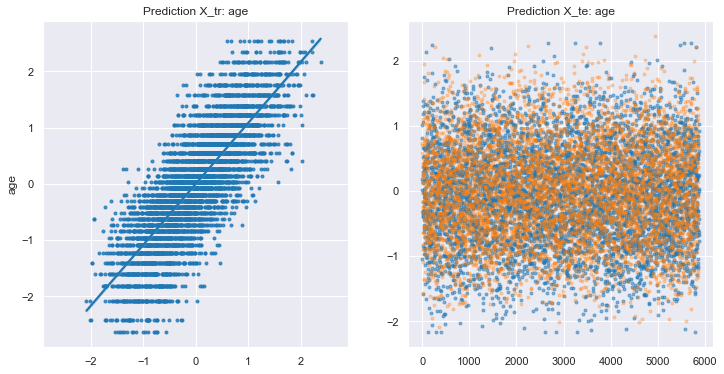

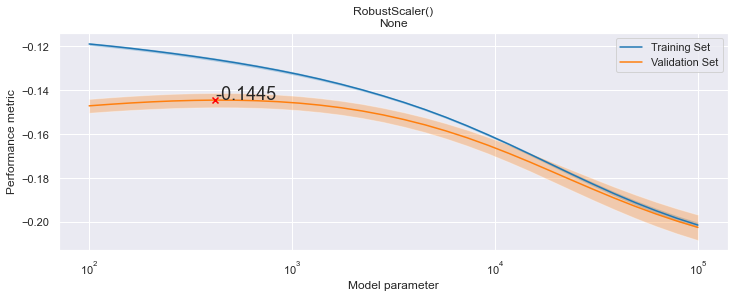

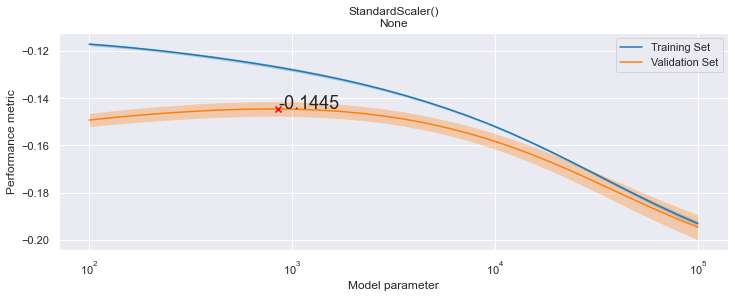

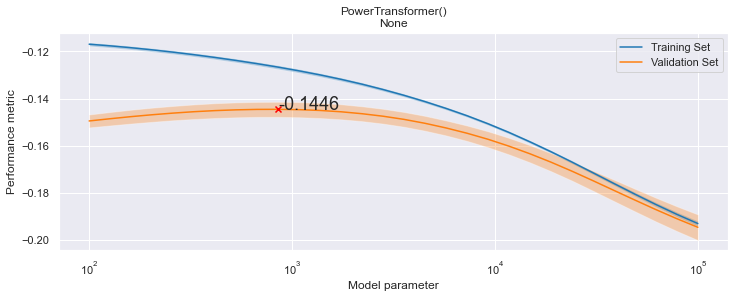

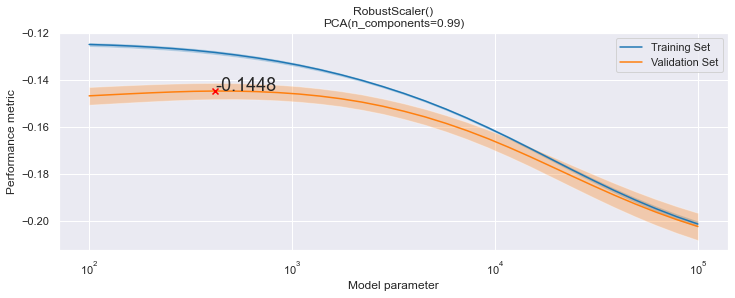

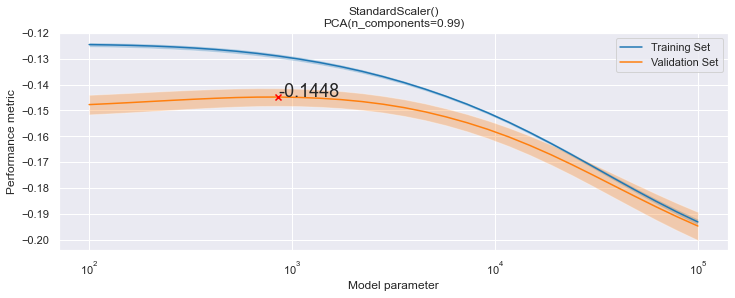

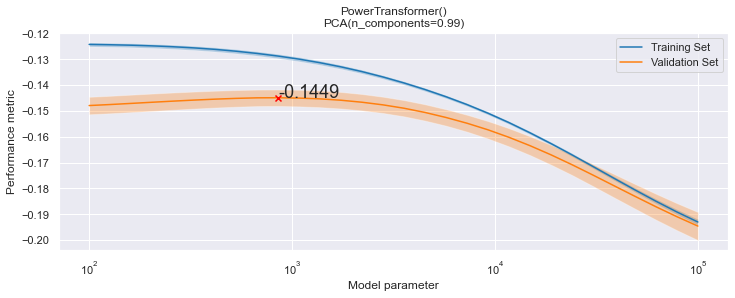

param_estimator__alpha param_estimator__tol param_pca        param_scaler  \
37                417.532               0.0001      None      RobustScaler()   
54                853.168               0.0001      None    StandardScaler()   
43                529.832               0.0001      None      RobustScaler()   
48                672.336               0.0001      None    StandardScaler()   
56                853.168               0.0001      None  PowerTransformer()   
50                672.336               0.0001      None  PowerTransformer()   
31                329.034               0.0001      None      RobustScaler()   
60                1082.64               0.0001      None    StandardScaler()   
62                1082.64               0.0001      None  PowerTransformer()   
42                529.832               0.0001      None    StandardScaler()   

    mean_test_score  std_test_score  mean_train_score  std_train_score  
37        -0.144494        0.003240         -0.126024         0.000789  
54        -0.144519        0.003243         -0.126809         0.000794  
43        -0.144542        0.003239         -0.127531         0.000791  
48        -0.144552        0.003237         -0.125345         0.000792  
56        -0.144557        0.003180         -0.126671         0.000801  
50        -0.144587        0.003152         -0.125209         0.000790  
31        -0.144623        0.003239         -0.124627         0.000785  
60        -0.144683        0.003231         -0.128389         0.000789  
62        -0.144697        0.003193         -0.128257         0.000787  
42        -0.144742        0.003228         -0.123988         0.000780

Starting with dataset merge - target: domain1_var1
Removing 437 missing values from target dataset.
Size of dataset:  (5428, 1405)
Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:  9.4min finished


Best: -0.152249 using {'estimator__alpha': 5736.152510448682, 'estimator__tol': 0.0001, 'pca': PCA(n_components=0.99), 'scaler': PowerTransformer()}


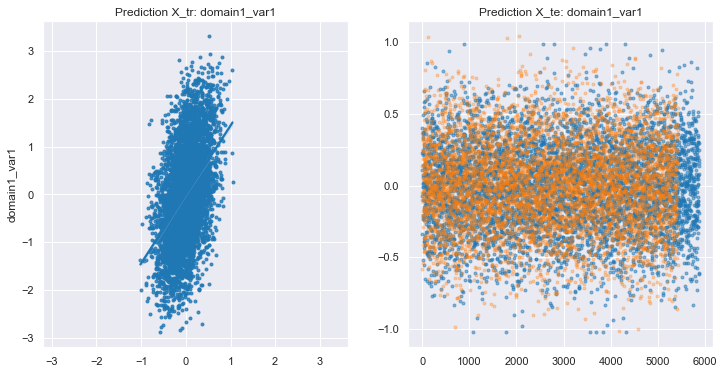

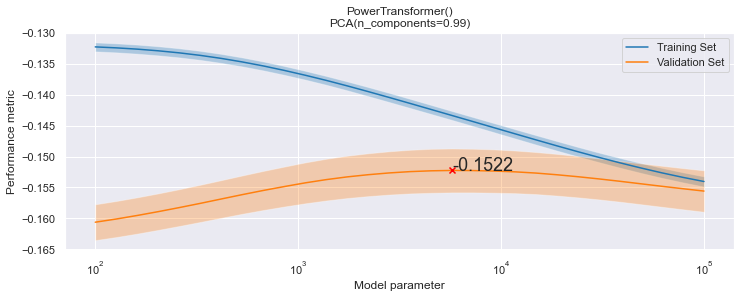

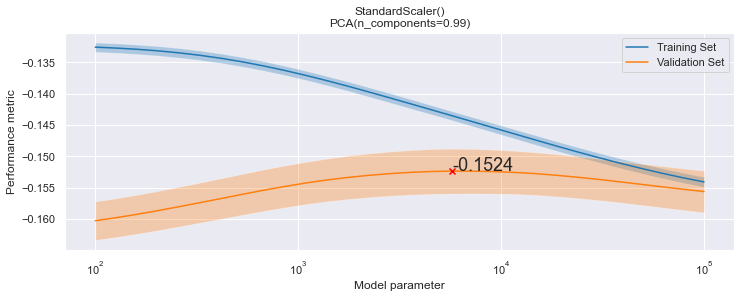

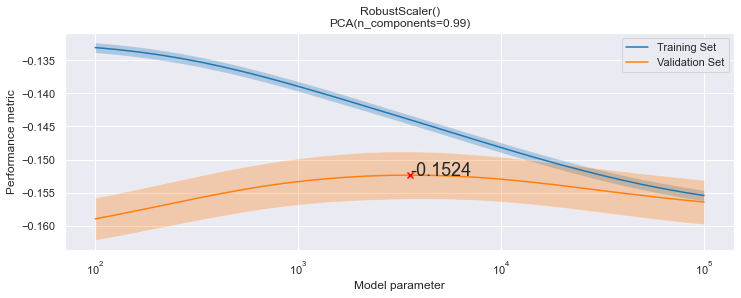

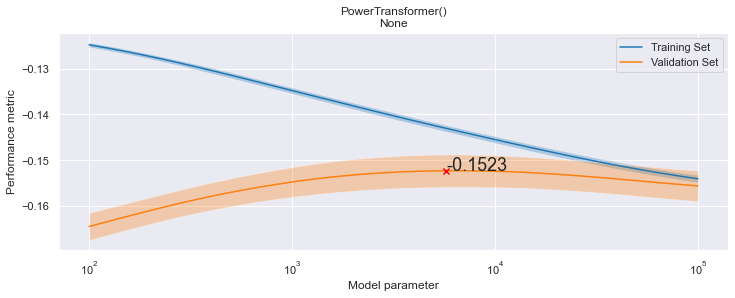

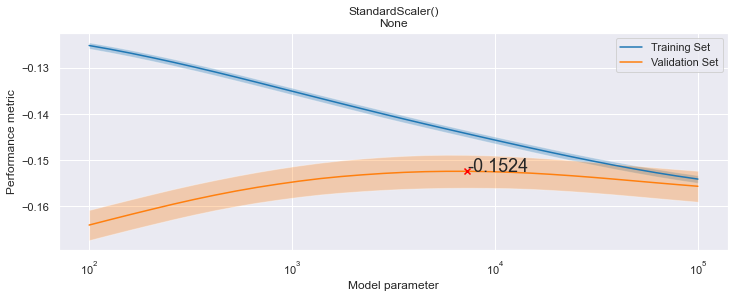

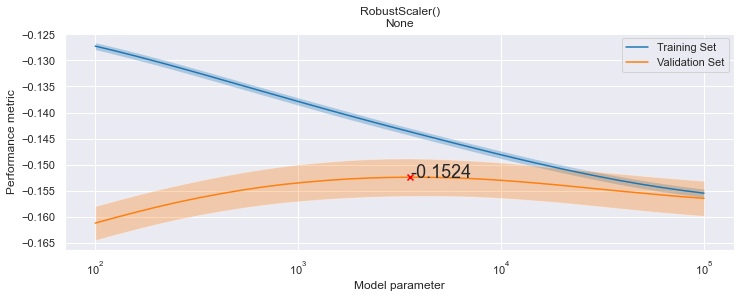

param_estimator__alpha param_estimator__tol               param_pca  \
107                5736.15               0.0001  PCA(n_components=0.99)   
113                7278.95               0.0001  PCA(n_components=0.99)   
104                5736.15               0.0001                    None   
110                7278.95               0.0001                    None   
101                4520.35               0.0001  PCA(n_components=0.99)   
98                 4520.35               0.0001                    None   
119                9236.71               0.0001  PCA(n_components=0.99)   
116                9236.71               0.0001                    None   
105                5736.15               0.0001  PCA(n_components=0.99)   
94                 3562.25               0.0001  PCA(n_components=0.99)   

           param_scaler  mean_test_score  std_test_score  mean_train_score  \
107  PowerTransformer()        -0.152249        0.003543         -0.143380   
113  PowerTransformer()        -0.152271        0.003522         -0.144360   
104  PowerTransformer()        -0.152271        0.003544         -0.143028   
110  PowerTransformer()        -0.152278        0.003525         -0.144084   
101  PowerTransformer()        -0.152309        0.003546         -0.142402   
98   PowerTransformer()        -0.152346        0.003543         -0.141956   
119  PowerTransformer()        -0.152347        0.003493         -0.145347   
116  PowerTransformer()        -0.152351        0.003494         -0.145131   
105    StandardScaler()        -0.152360        0.003584         -0.143527   
94       RobustScaler()        -0.152366        0.003594         -0.143989   

     std_train_score  
107         0.000719  
113         0.000721  
104         0.000716  
110         0.000719  
101         0.000725  
98          0.000718  
119         0.000731  
116         0.000728  
105         0.000736  
94          0.000734

Starting with dataset merge - target: domain1_var2
Removing 437 missing values from target dataset.
Size of dataset:  (5428, 1405)
Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:  9.5min finished


Best: -0.150616 using {'estimator__alpha': 48939.00918477499, 'estimator__tol': 0.0001, 'pca': None, 'scaler': StandardScaler()}


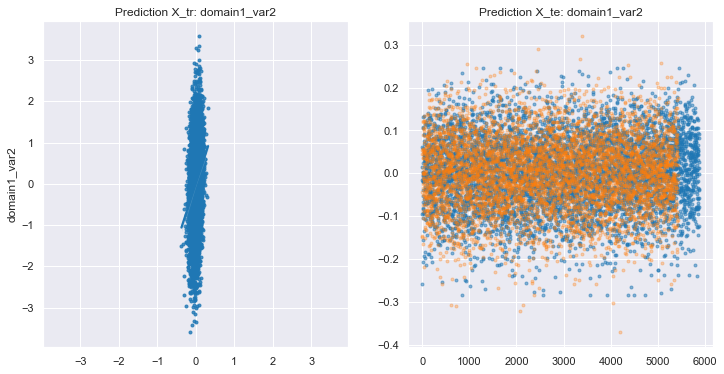

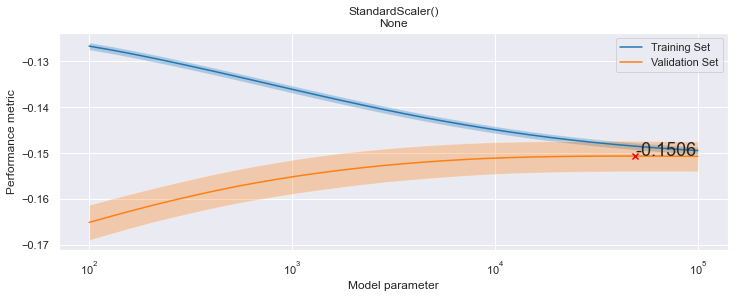

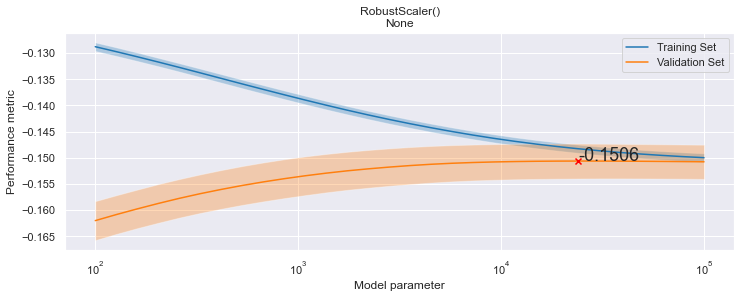

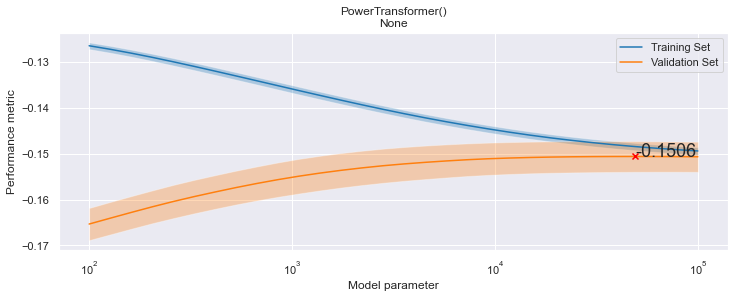

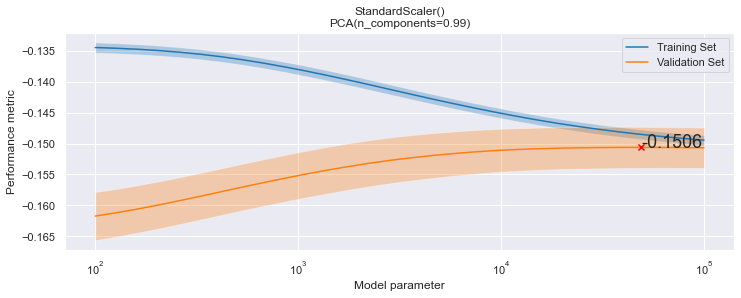

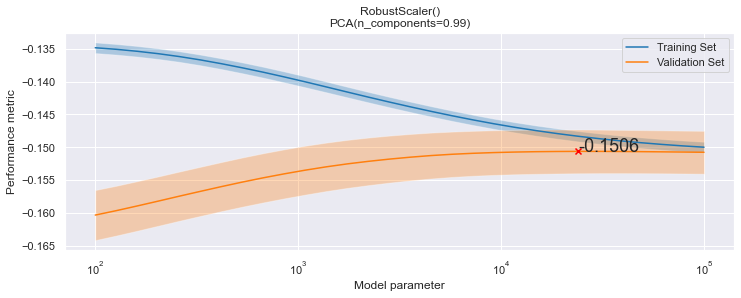

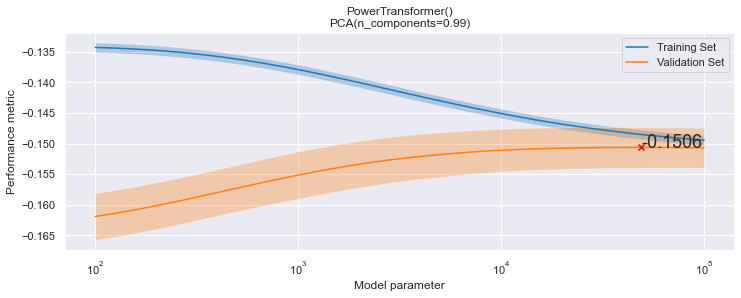

param_estimator__alpha param_estimator__tol               param_pca  \
156                  48939               0.0001                    None   
159                  48939               0.0001  PCA(n_components=0.99)   
150                38566.2               0.0001                    None   
139                23950.3               0.0001                    None   
158                  48939               0.0001                    None   
153                38566.2               0.0001  PCA(n_components=0.99)   
145                  30392               0.0001                    None   
142                23950.3               0.0001  PCA(n_components=0.99)   
162                62101.7               0.0001                    None   
152                38566.2               0.0001                    None   

           param_scaler  mean_test_score  std_test_score  mean_train_score  \
156    StandardScaler()        -0.150616        0.003326         -0.148466   
159    StandardScaler()        -0.150620        0.003326         -0.148510   
150    StandardScaler()        -0.150621        0.003347         -0.148067   
139      RobustScaler()        -0.150624        0.003332         -0.148272   
158  PowerTransformer()        -0.150625        0.003332         -0.148459   
153    StandardScaler()        -0.150626        0.003347         -0.148124   
145      RobustScaler()        -0.150627        0.003312         -0.148649   
142      RobustScaler()        -0.150628        0.003331         -0.148322   
162    StandardScaler()        -0.150628        0.003305         -0.148823   
152  PowerTransformer()        -0.150629        0.003355         -0.148060   

     std_train_score  
156         0.000790  
159         0.000791  
150         0.000786  
139         0.000784  
158         0.000791  
153         0.000787  
145         0.000790  
142         0.000785  
162         0.000795  
152         0.000787

Starting with dataset merge - target: domain2_var1
Removing 39 missing values from target dataset.
Size of dataset:  (5826, 1405)
Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed: 10.0min finished


Best: -0.182063 using {'estimator__alpha': 4520.35365636024, 'estimator__tol': 0.0001, 'pca': None, 'scaler': RobustScaler()}


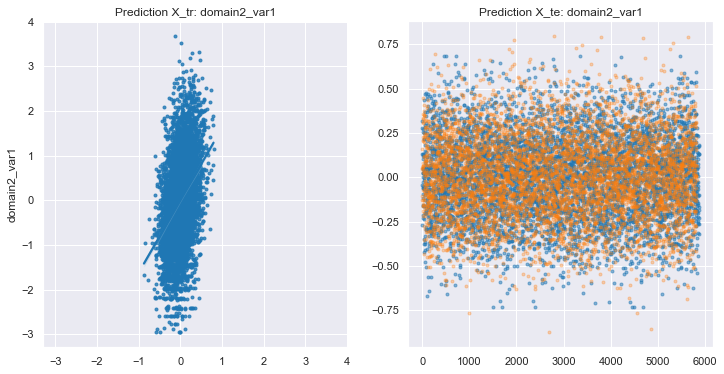

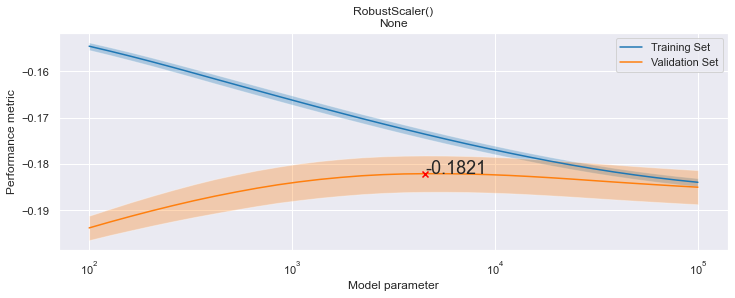

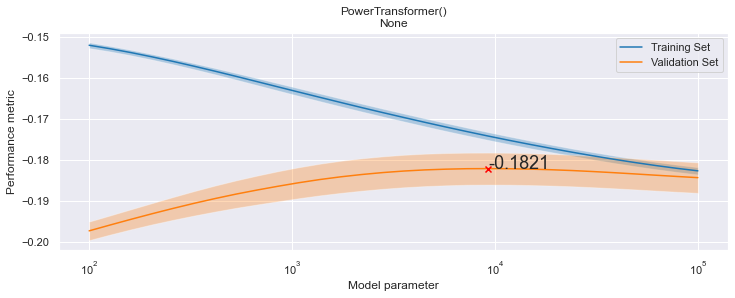

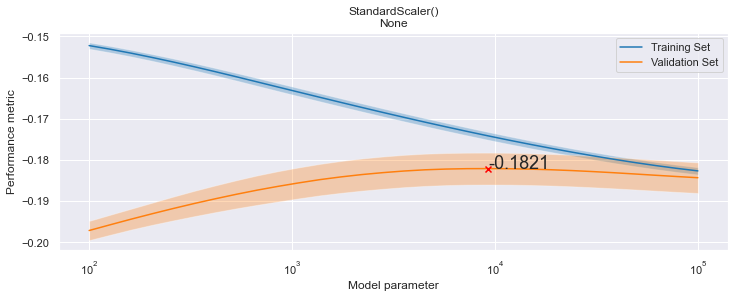

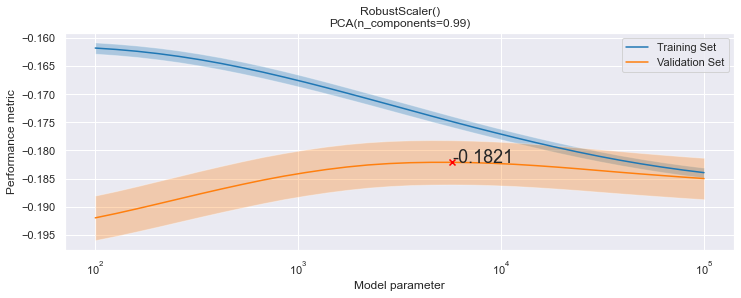

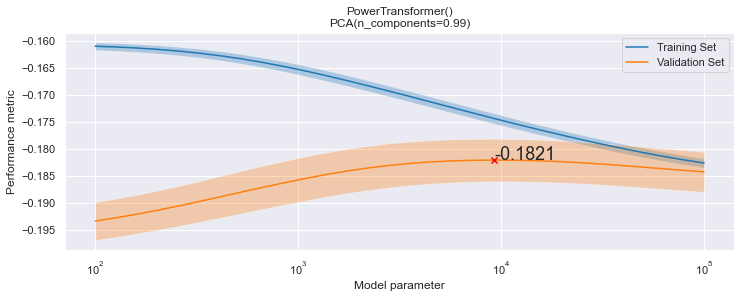

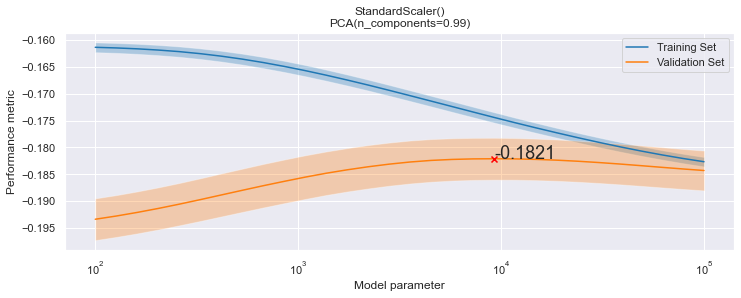

param_estimator__alpha param_estimator__tol               param_pca  \
97                 4520.35               0.0001                    None   
103                5736.15               0.0001                    None   
116                9236.71               0.0001                    None   
114                9236.71               0.0001                    None   
106                5736.15               0.0001  PCA(n_components=0.99)   
100                4520.35               0.0001  PCA(n_components=0.99)   
108                7278.95               0.0001                    None   
110                7278.95               0.0001                    None   
91                 3562.25               0.0001                    None   
119                9236.71               0.0001  PCA(n_components=0.99)   

           param_scaler  mean_test_score  std_test_score  mean_train_score  \
97       RobustScaler()        -0.182063        0.003910         -0.173553   
103      RobustScaler()        -0.182071        0.003897         -0.174621   
116  PowerTransformer()        -0.182093        0.003900         -0.174138   
114    StandardScaler()        -0.182095        0.003873         -0.174140   
106      RobustScaler()        -0.182102        0.003923         -0.174870   
100      RobustScaler()        -0.182103        0.003947         -0.173869   
108    StandardScaler()        -0.182116        0.003874         -0.173058   
110  PowerTransformer()        -0.182119        0.003906         -0.173057   
91       RobustScaler()        -0.182122        0.003922         -0.172453   
119  PowerTransformer()        -0.182124        0.003941         -0.174420   

     std_train_score  
97          0.000965  
103         0.000952  
116         0.000948  
114         0.000947  
106         0.000964  
100         0.000981  
108         0.000959  
110         0.000958  
91          0.000976  
119         0.000958

Starting with dataset merge - target: domain2_var2
Removing 39 missing values from target dataset.
Size of dataset:  (5826, 1405)
Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed: 10.0min finished


Best: -0.175969 using {'estimator__alpha': 9236.708571873865, 'estimator__tol': 0.0001, 'pca': None, 'scaler': RobustScaler()}


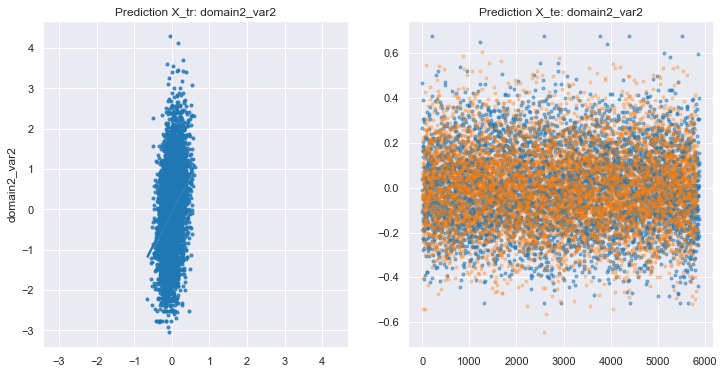

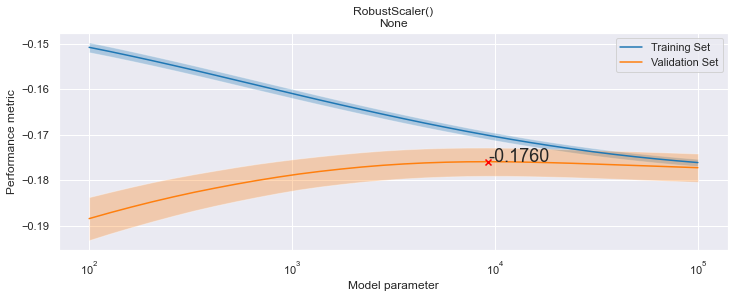

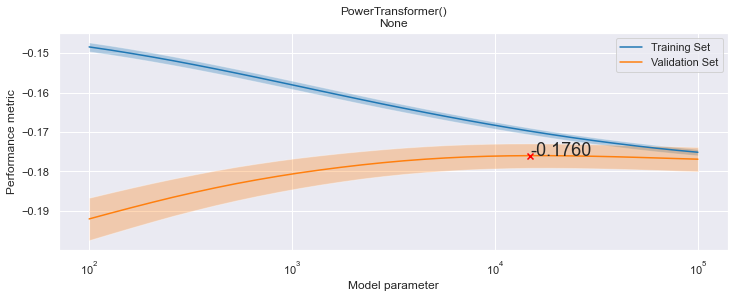

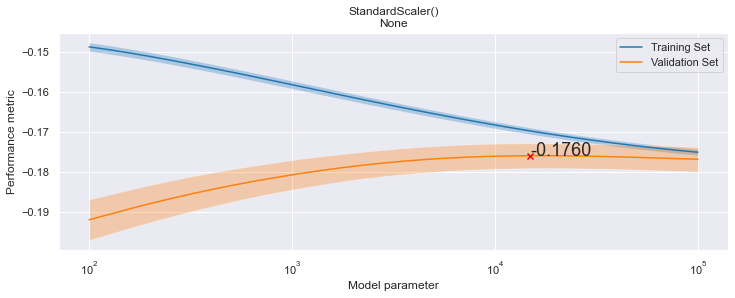

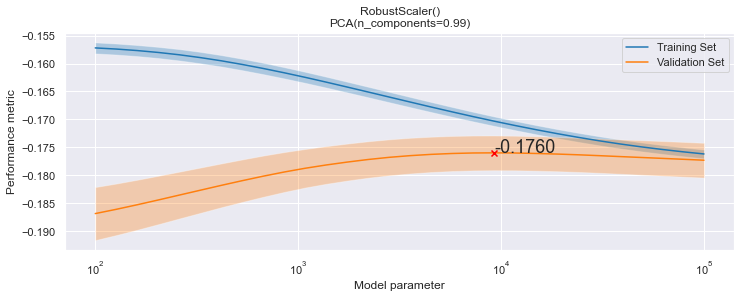

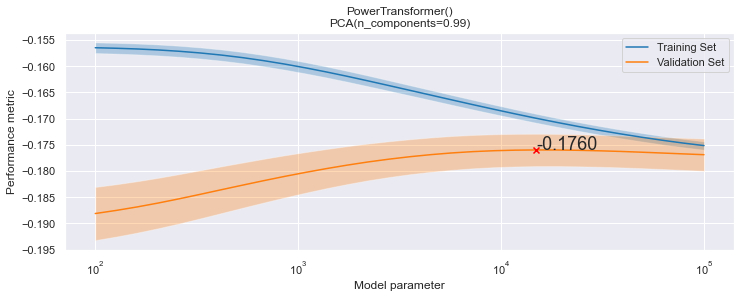

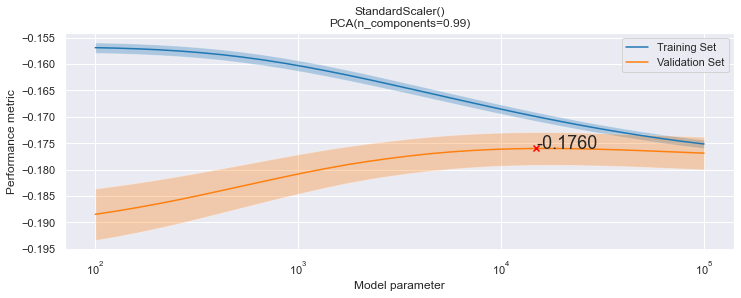

param_estimator__alpha param_estimator__tol               param_pca  \
115                9236.71               0.0001                    None   
131                14873.5               0.0001  PCA(n_components=0.99)   
118                9236.71               0.0001  PCA(n_components=0.99)   
137                18873.9               0.0001  PCA(n_components=0.99)   
128                14873.5               0.0001                    None   
134                18873.9               0.0001                    None   
126                14873.5               0.0001                    None   
129                14873.5               0.0001  PCA(n_components=0.99)   
132                18873.9               0.0001                    None   
109                7278.95               0.0001                    None   

           param_scaler  mean_test_score  std_test_score  mean_train_score  \
115      RobustScaler()        -0.175969        0.003102         -0.170168   
131  PowerTransformer()        -0.175971        0.003084         -0.169922   
118      RobustScaler()        -0.175973        0.003103         -0.170304   
137  PowerTransformer()        -0.175980        0.003069         -0.170721   
128  PowerTransformer()        -0.175982        0.003086         -0.169772   
134  PowerTransformer()        -0.175988        0.003071         -0.170603   
126    StandardScaler()        -0.175991        0.003115         -0.169792   
129    StandardScaler()        -0.175992        0.003113         -0.169944   
132    StandardScaler()        -0.175992        0.003101         -0.170618   
109      RobustScaler()        -0.175994        0.003118         -0.169317   

     std_train_score  
115         0.000833  
131         0.000848  
118         0.000836  
137         0.000833  
128         0.000847  
134         0.000831  
126         0.000844  
129         0.000846  
132         0.000826  
109         0.000851

score  estimator__alpha  estimator__tol                     pca  \
0  0.144494        417.531894          0.0001                    None   
1  0.152249       5736.152510          0.0001  PCA(n_components=0.99)   
2  0.150616      48939.009185          0.0001                    None   
3  0.182063       4520.353656          0.0001                    None   
4  0.175969       9236.708572          0.0001                    None   

               scaler  
0      RobustScaler()  
1  PowerTransformer()  
2    StandardScaler()  
3      RobustScaler()  
4      RobustScaler()

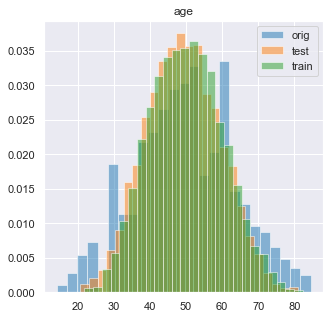

/home/mnotter/miniconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/mnotter/miniconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


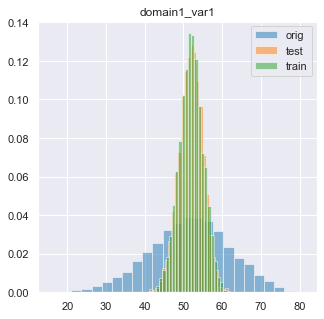

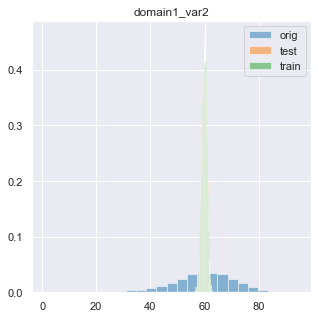

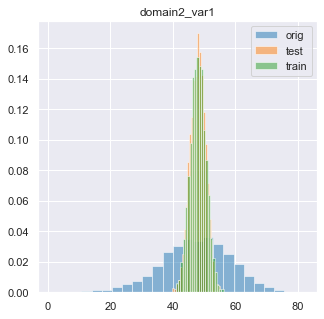

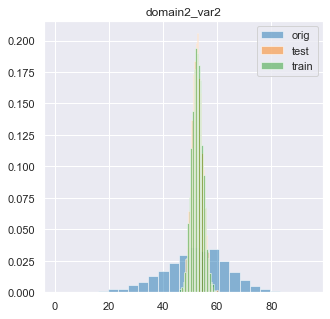

Score: 0.1590 | -0.1445 -0.1522 -0.1506 -0.1821 -0.1760


In [20]:
datasets_to_check = ['merge']

for dataset_id in datasets_to_check:

    predictions = {}
    scores = []
    grids = []

    for tidx, target in enumerate(['age', 'domain1_var1', 'domain1_var2', 'domain2_var1', 'domain2_var2']):

        print('Starting with dataset %s - target: %s' % (dataset_id, target))
        estimator = Ridge()
        df_pred, pred_tr, pred_te, grid, idx = run_prediction(model_metric,
            dataset_id=dataset_id, target=target, estimator=estimator,
            scaler_targets=scaler_targets, tidx=tidx)
        
        display_grid_optimization_details(grid)

        predictions['%s_tr' % target] = pred_tr
        predictions['%s_te' % target] = pred_te
        predictions['%s_miss' % target] = idx
        
        scores.append(grid.best_score_)
        grids.append(grid)

    # Display grids summary
    grids_summary(grids)
    
    # Compute overall score
    weights = [.3, .175, .175, .175, .175]
    score = np.sum([-s * weights[i] for i, s in enumerate(scores)])
    score_postfix = [int(score*10000)] + [-int(s*10000) for i, s in enumerate(scores)]

    df_results_tr, df_results_te = save_results(
        predictions, scaler_targets, targets, test_id, feature_transform,
        sample_submission, dataset_id, score_postfix)

    plot_prediction_distributions(targets, scaler_targets, df_results_tr, df_results_te)
    
    # Feedback of overall score
    txt = 'Score: {:.4f} | {:.4f} {:.4f} {:.4f} {:.4f} {:.4f}'.format(score, *scores)
    print(txt)

Starting with dataset short_merge - target: age
Removing 0 missing values from target dataset.
Size of dataset:  (5825, 1655)
Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed: 12.8min finished


Best: -0.143942 using {'estimator__alpha': 853.1678524172805, 'estimator__tol': 0.0001, 'pca': None, 'scaler': PowerTransformer()}


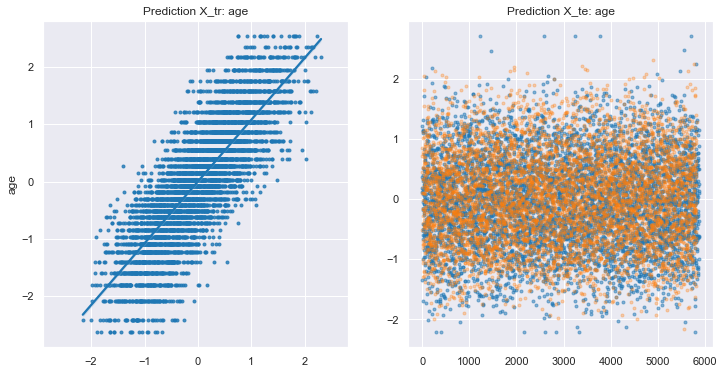

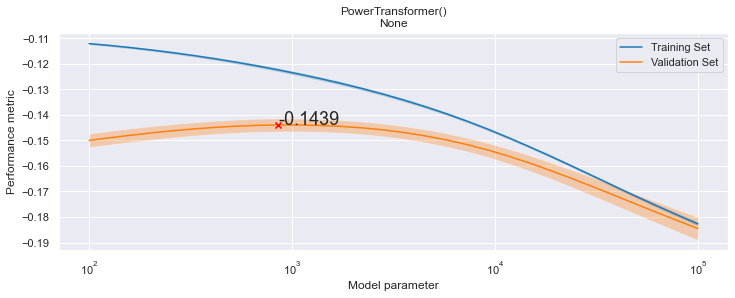

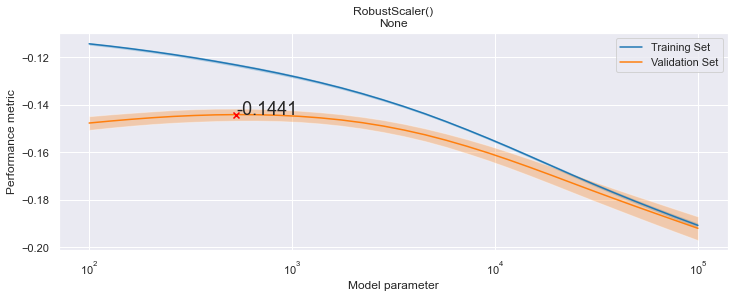

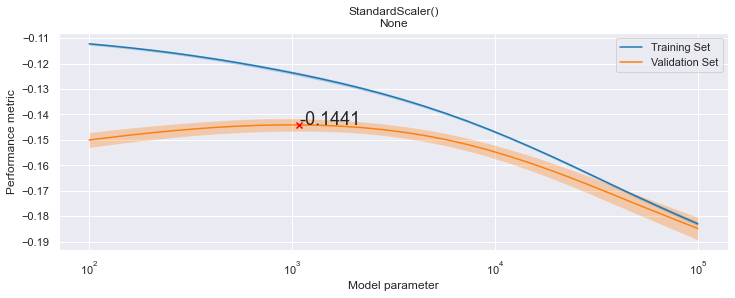

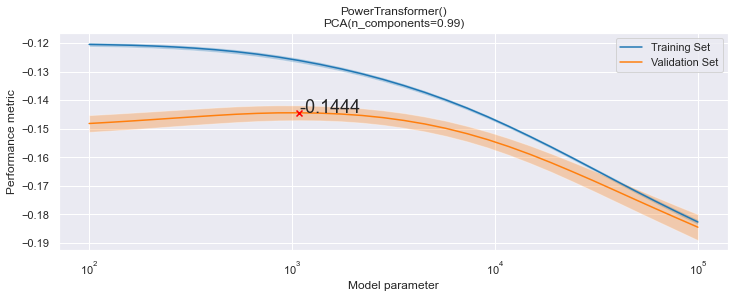

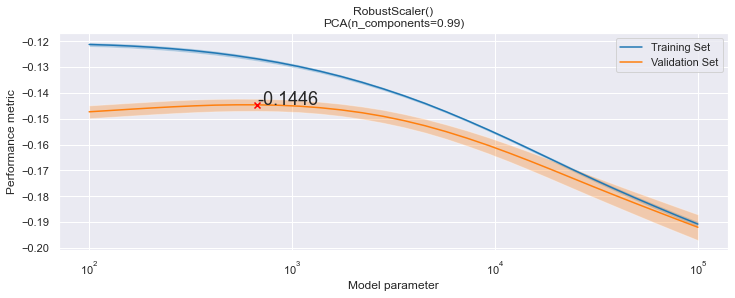

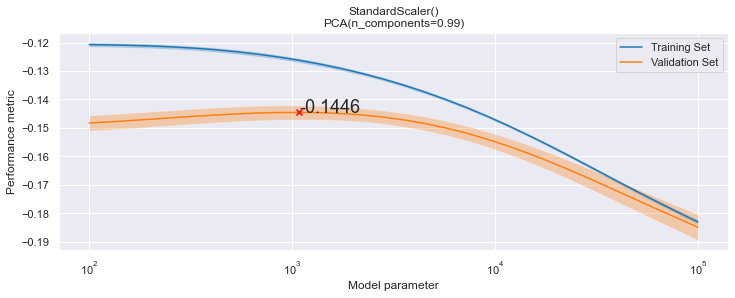

param_estimator__alpha param_estimator__tol param_pca        param_scaler  \
56                853.168               0.0001      None  PowerTransformer()   
62                1082.64               0.0001      None  PowerTransformer()   
50                672.336               0.0001      None  PowerTransformer()   
43                529.832               0.0001      None      RobustScaler()   
60                1082.64               0.0001      None    StandardScaler()   
68                1373.82               0.0001      None  PowerTransformer()   
54                853.168               0.0001      None    StandardScaler()   
49                672.336               0.0001      None      RobustScaler()   
37                417.532               0.0001      None      RobustScaler()   
66                1373.82               0.0001      None    StandardScaler()   

    mean_test_score  std_test_score  mean_train_score  std_train_score  
56        -0.143942        0.002545         -0.122360         0.000720  
62        -0.143963        0.002511         -0.124011         0.000744  
50        -0.144099        0.002561         -0.120814         0.000692  
43        -0.144112        0.002529         -0.123213         0.000720  
60        -0.144128        0.002543         -0.124186         0.000729  
68        -0.144149        0.002465         -0.125774         0.000750  
54        -0.144150        0.002620         -0.122558         0.000714  
49        -0.144169        0.002455         -0.124870         0.000735  
37        -0.144224        0.002600         -0.121658         0.000700  
66        -0.144285        0.002474         -0.125928         0.000728

Starting with dataset short_merge - target: domain1_var1
Removing 435 missing values from target dataset.
Size of dataset:  (5390, 1655)
Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed: 12.1min finished


Best: -0.150069 using {'estimator__alpha': 5736.152510448682, 'estimator__tol': 0.0001, 'pca': PCA(n_components=0.99), 'scaler': PowerTransformer()}


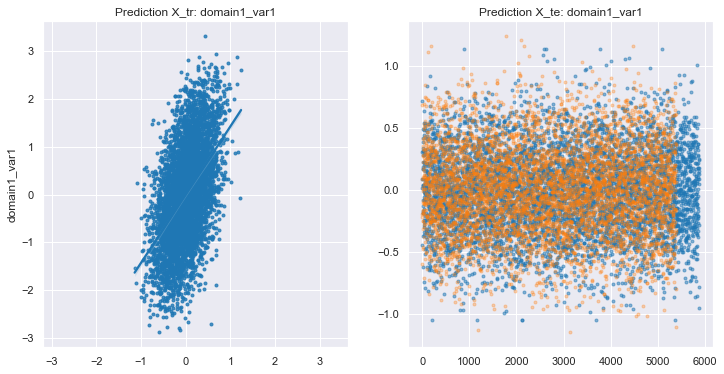

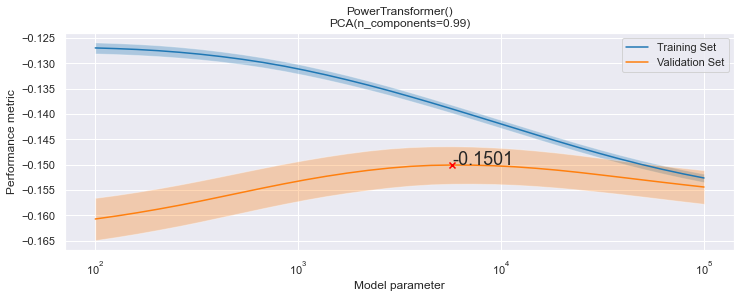

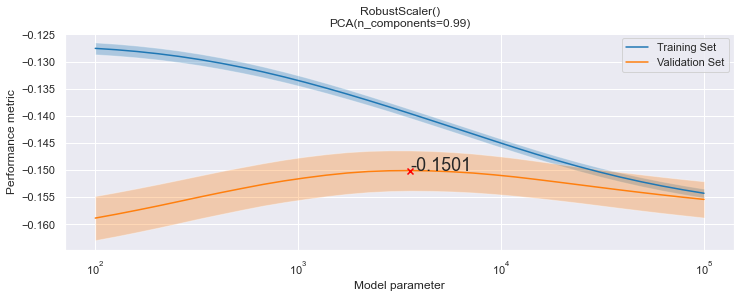

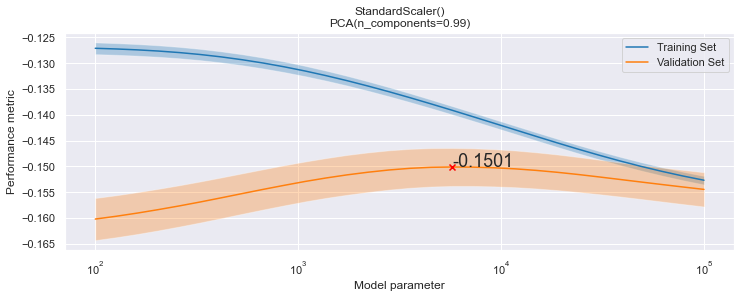

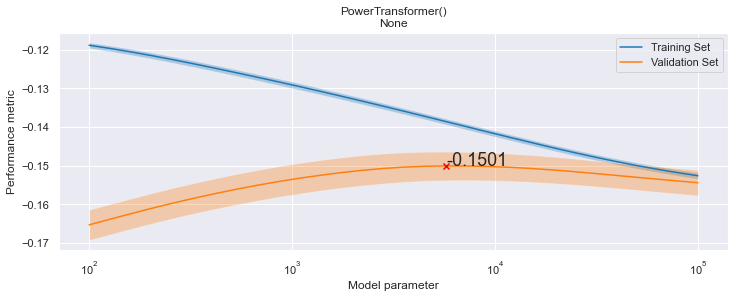

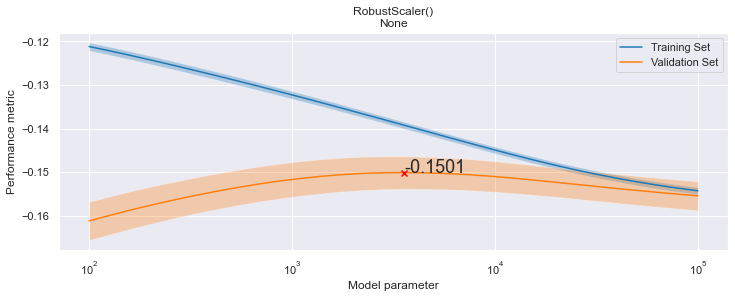

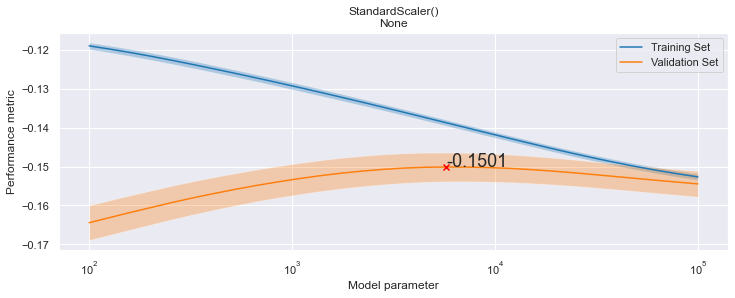

param_estimator__alpha param_estimator__tol               param_pca  \
107                5736.15               0.0001  PCA(n_components=0.99)   
104                5736.15               0.0001                    None   
113                7278.95               0.0001  PCA(n_components=0.99)   
110                7278.95               0.0001                    None   
91                 3562.25               0.0001                    None   
105                5736.15               0.0001  PCA(n_components=0.99)   
94                 3562.25               0.0001  PCA(n_components=0.99)   
102                5736.15               0.0001                    None   
111                7278.95               0.0001  PCA(n_components=0.99)   
108                7278.95               0.0001                    None   

           param_scaler  mean_test_score  std_test_score  mean_train_score  \
107  PowerTransformer()        -0.150069        0.003693         -0.139004   
104  PowerTransformer()        -0.150078        0.003720         -0.138606   
113  PowerTransformer()        -0.150093        0.003653         -0.140269   
110  PowerTransformer()        -0.150097        0.003679         -0.139957   
91       RobustScaler()        -0.150106        0.003734         -0.139233   
105    StandardScaler()        -0.150109        0.003672         -0.139119   
94       RobustScaler()        -0.150112        0.003706         -0.139596   
102    StandardScaler()        -0.150113        0.003711         -0.138716   
111    StandardScaler()        -0.150138        0.003641         -0.140373   
108    StandardScaler()        -0.150139        0.003673         -0.140055   

     std_train_score  
107         0.000799  
104         0.000781  
113         0.000797  
110         0.000783  
91          0.000802  
105         0.000804  
94          0.000809  
102         0.000796  
111         0.000796  
108         0.000791

Starting with dataset short_merge - target: domain1_var2
Removing 435 missing values from target dataset.
Size of dataset:  (5390, 1655)
Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed: 12.1min finished


Best: -0.147738 using {'estimator__alpha': 4520.35365636024, 'estimator__tol': 0.0001, 'pca': None, 'scaler': RobustScaler()}


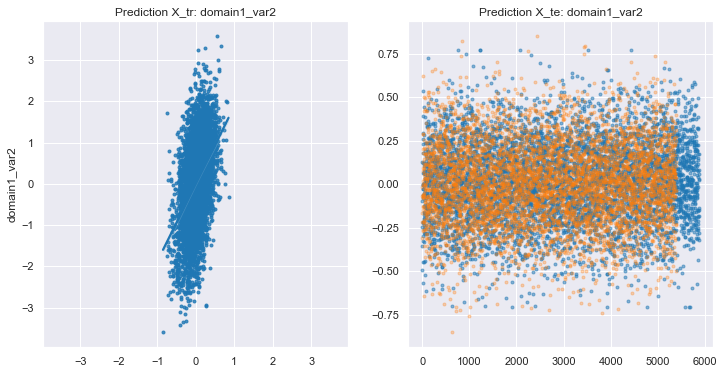

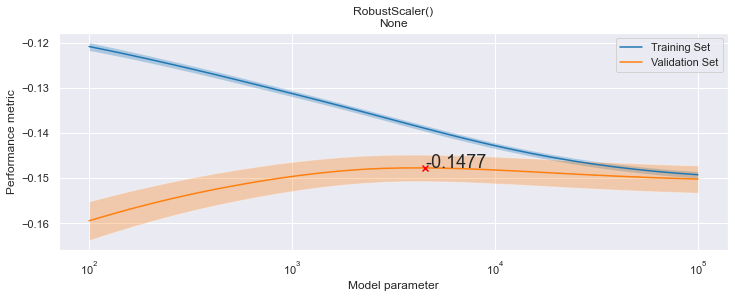

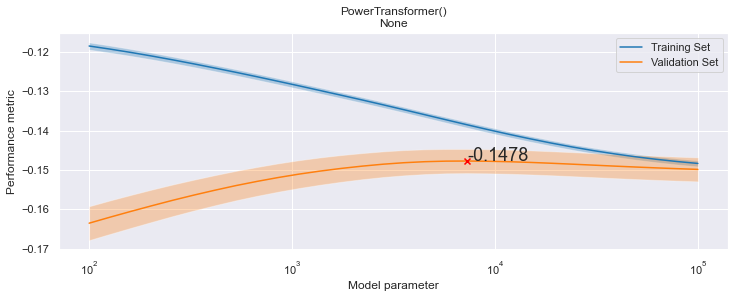

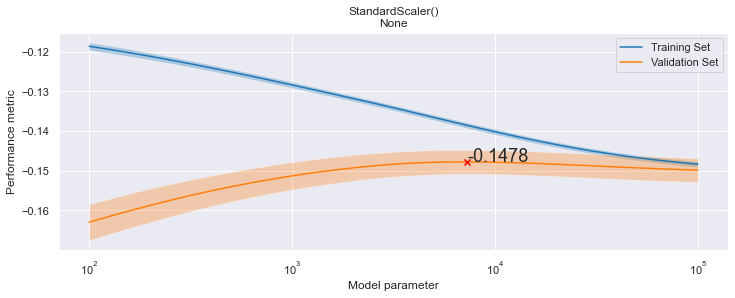

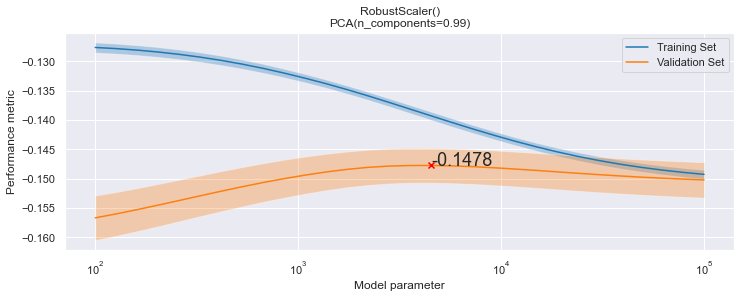

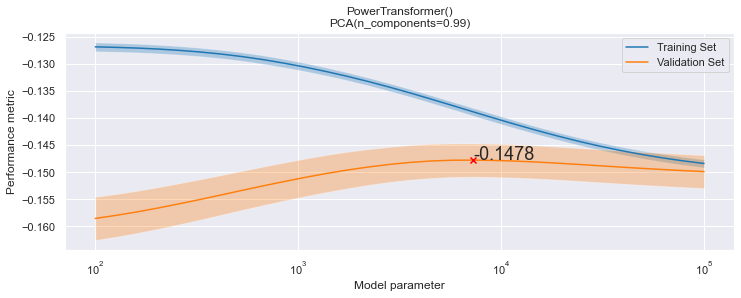

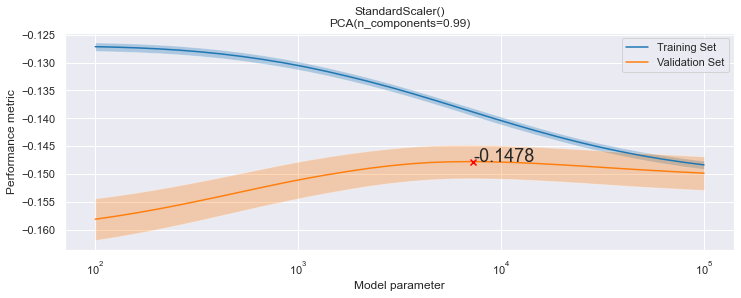

param_estimator__alpha param_estimator__tol               param_pca  \
97                 4520.35               0.0001                    None   
91                 3562.25               0.0001                    None   
100                4520.35               0.0001  PCA(n_components=0.99)   
110                7278.95               0.0001                    None   
94                 3562.25               0.0001  PCA(n_components=0.99)   
113                7278.95               0.0001  PCA(n_components=0.99)   
104                5736.15               0.0001                    None   
107                5736.15               0.0001  PCA(n_components=0.99)   
108                7278.95               0.0001                    None   
111                7278.95               0.0001  PCA(n_components=0.99)   

           param_scaler  mean_test_score  std_test_score  mean_train_score  \
97       RobustScaler()        -0.147738        0.002936         -0.138978   
91       RobustScaler()        -0.147745        0.002941         -0.137747   
100      RobustScaler()        -0.147754        0.002932         -0.139286   
110  PowerTransformer()        -0.147755        0.003061         -0.138533   
94       RobustScaler()        -0.147760        0.002936         -0.138138   
113  PowerTransformer()        -0.147769        0.003063         -0.138861   
104  PowerTransformer()        -0.147783        0.003087         -0.137268   
107  PowerTransformer()        -0.147792        0.003089         -0.137684   
108    StandardScaler()        -0.147793        0.002998         -0.138569   
111    StandardScaler()        -0.147801        0.002988         -0.138901   

     std_train_score  
97          0.000697  
91          0.000685  
100         0.000699  
110         0.000724  
94          0.000688  
113         0.000724  
104         0.000715  
107         0.000717  
108         0.000711  
111         0.000706

Starting with dataset short_merge - target: domain2_var1
Removing 39 missing values from target dataset.
Size of dataset:  (5786, 1655)
Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed: 12.7min finished


Best: -0.179970 using {'estimator__alpha': 4520.35365636024, 'estimator__tol': 0.0001, 'pca': None, 'scaler': RobustScaler()}


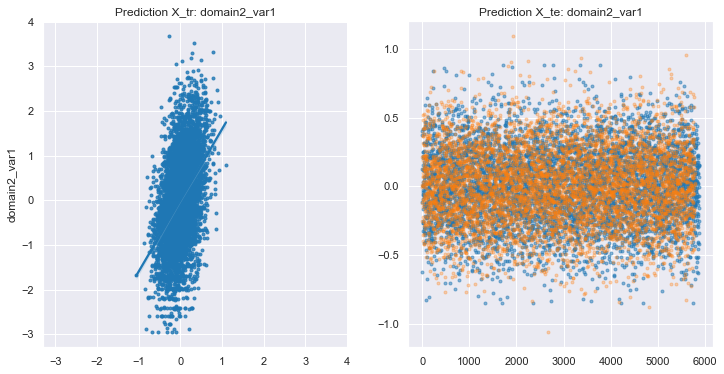

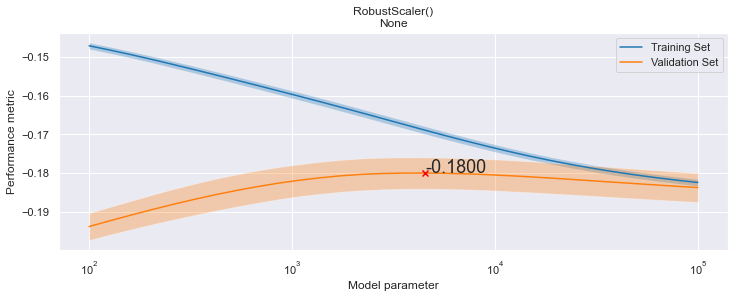

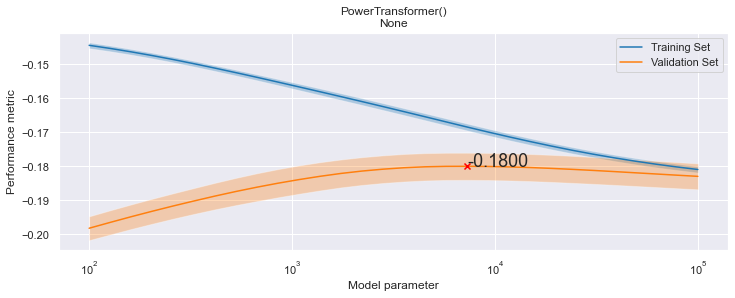

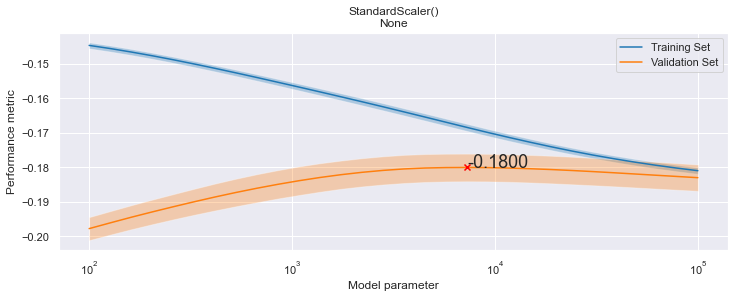

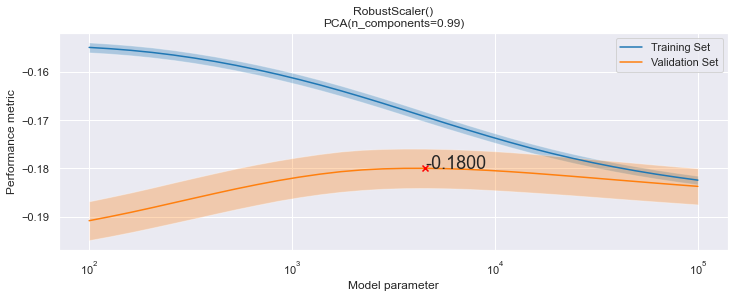

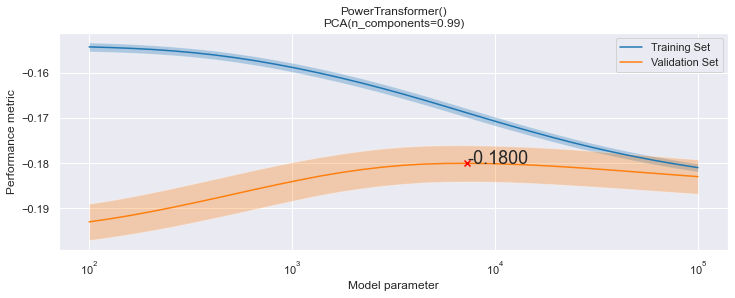

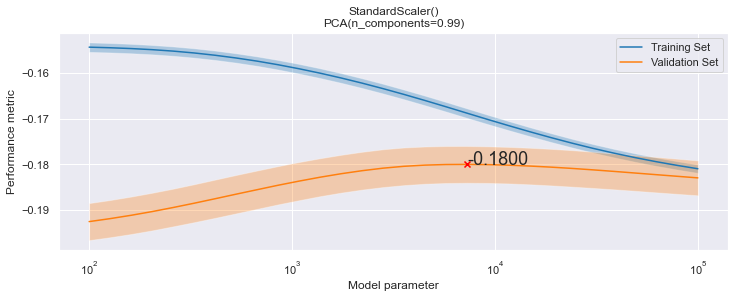

param_estimator__alpha param_estimator__tol               param_pca  \
97                 4520.35               0.0001                    None   
100                4520.35               0.0001  PCA(n_components=0.99)   
94                 3562.25               0.0001  PCA(n_components=0.99)   
91                 3562.25               0.0001                    None   
110                7278.95               0.0001                    None   
104                5736.15               0.0001                    None   
108                7278.95               0.0001                    None   
113                7278.95               0.0001  PCA(n_components=0.99)   
111                7278.95               0.0001  PCA(n_components=0.99)   
107                5736.15               0.0001  PCA(n_components=0.99)   

           param_scaler  mean_test_score  std_test_score  mean_train_score  \
97       RobustScaler()        -0.179970        0.004066         -0.168887   
100      RobustScaler()        -0.179976        0.004081         -0.169247   
94       RobustScaler()        -0.179987        0.004099         -0.167861   
91       RobustScaler()        -0.179988        0.004077         -0.167404   
110  PowerTransformer()        -0.179988        0.003984         -0.168428   
104  PowerTransformer()        -0.180004        0.003990         -0.166919   
108    StandardScaler()        -0.180005        0.003998         -0.168401   
113  PowerTransformer()        -0.180009        0.004017         -0.168829   
111    StandardScaler()        -0.180015        0.004021         -0.168794   
107  PowerTransformer()        -0.180031        0.004030         -0.167428   

     std_train_score  
97          0.001030  
100         0.001046  
94          0.001058  
91          0.001039  
110         0.001006  
104         0.001014  
108         0.001020  
113         0.001026  
111         0.001038  
107         0.001037

Starting with dataset short_merge - target: domain2_var2
Removing 39 missing values from target dataset.
Size of dataset:  (5786, 1655)
Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed: 12.7min finished


Best: -0.173367 using {'estimator__alpha': 5736.152510448682, 'estimator__tol': 0.0001, 'pca': PCA(n_components=0.99), 'scaler': RobustScaler()}


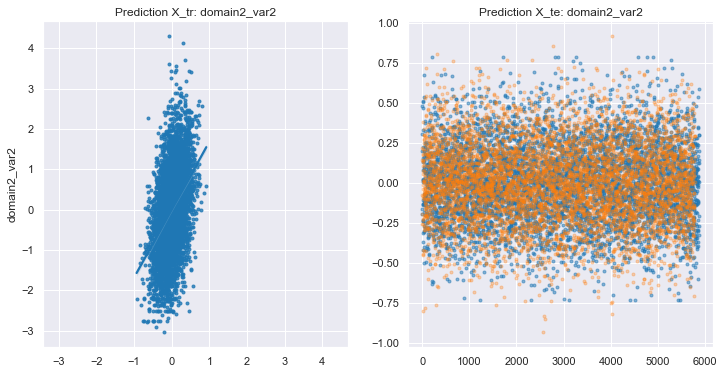

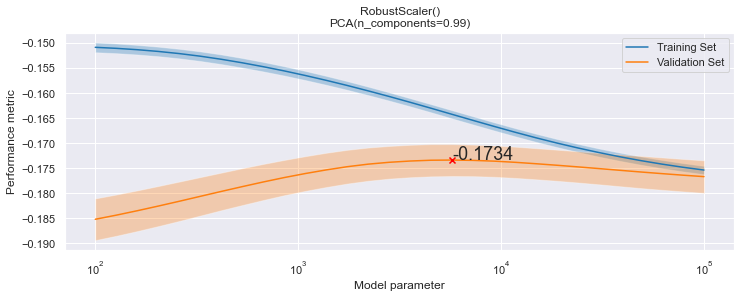

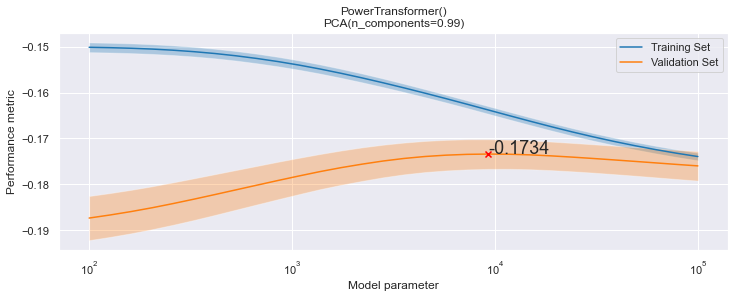

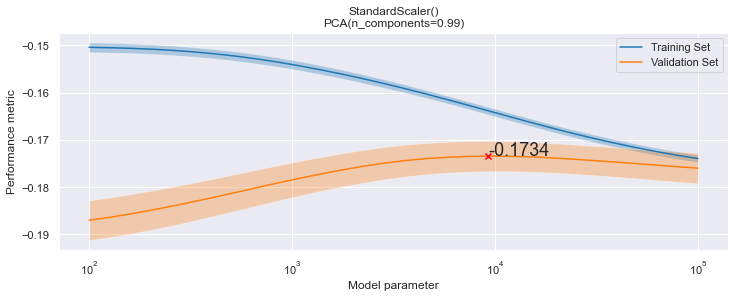

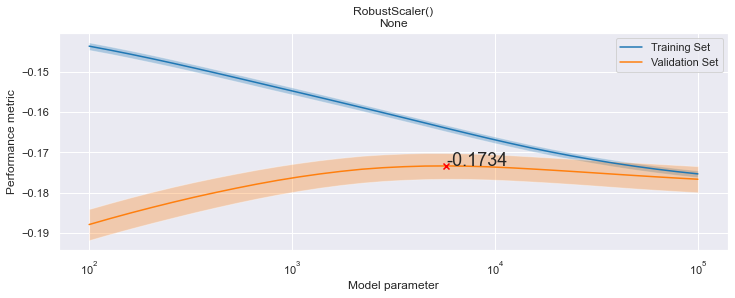

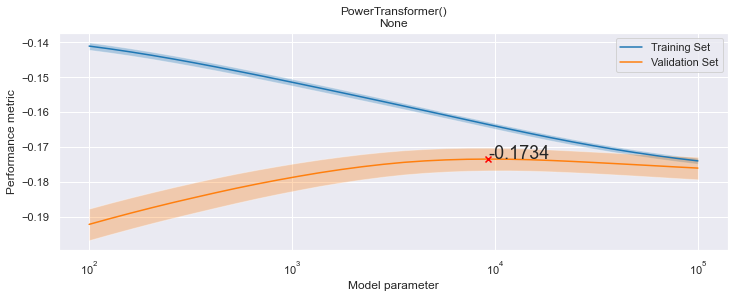

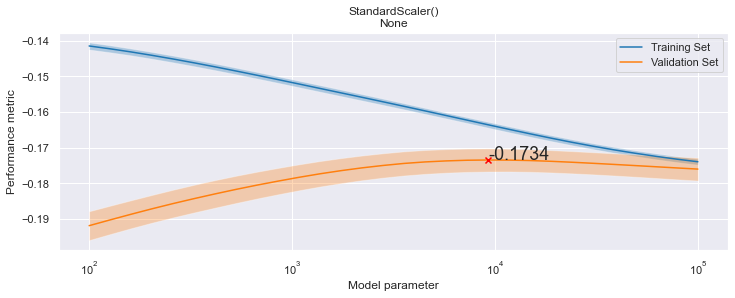

param_estimator__alpha param_estimator__tol               param_pca  \
106                5736.15               0.0001  PCA(n_components=0.99)   
103                5736.15               0.0001                    None   
100                4520.35               0.0001  PCA(n_components=0.99)   
116                9236.71               0.0001                    None   
97                 4520.35               0.0001                    None   
119                9236.71               0.0001  PCA(n_components=0.99)   
112                7278.95               0.0001  PCA(n_components=0.99)   
109                7278.95               0.0001                    None   
117                9236.71               0.0001  PCA(n_components=0.99)   
114                9236.71               0.0001                    None   

           param_scaler  mean_test_score  std_test_score  mean_train_score  \
106      RobustScaler()        -0.173367        0.003182         -0.164234   
103      RobustScaler()        -0.173372        0.003201         -0.163976   
100      RobustScaler()        -0.173402        0.003214         -0.163017   
116  PowerTransformer()        -0.173405        0.003242         -0.163497   
97       RobustScaler()        -0.173406        0.003234         -0.162689   
119  PowerTransformer()        -0.173406        0.003226         -0.163781   
112      RobustScaler()        -0.173432        0.003145         -0.165444   
109      RobustScaler()        -0.173435        0.003165         -0.165241   
117    StandardScaler()        -0.173437        0.003213         -0.163836   
114    StandardScaler()        -0.173441        0.003230         -0.163556   

     std_train_score  
106         0.000810  
103         0.000804  
100         0.000807  
116         0.000818  
97          0.000800  
119         0.000827  
112         0.000811  
109         0.000809  
117         0.000821  
114         0.000810

score  estimator__alpha  estimator__tol                     pca  \
0  0.143942        853.167852          0.0001                    None   
1  0.150069       5736.152510          0.0001  PCA(n_components=0.99)   
2  0.147738       4520.353656          0.0001                    None   
3  0.179970       4520.353656          0.0001                    None   
4  0.173367       5736.152510          0.0001  PCA(n_components=0.99)   

               scaler  
0  PowerTransformer()  
1  PowerTransformer()  
2      RobustScaler()  
3      RobustScaler()  
4      RobustScaler()

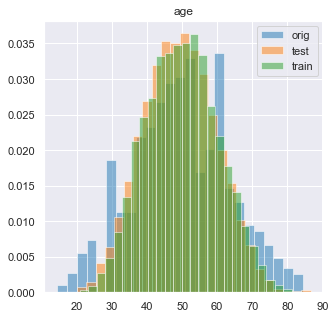

/home/mnotter/miniconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/mnotter/miniconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


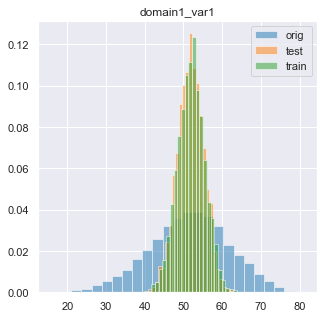

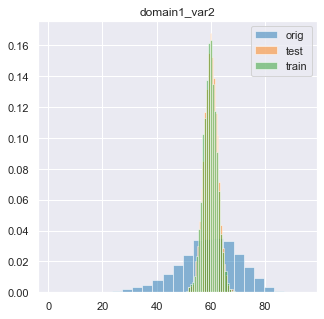

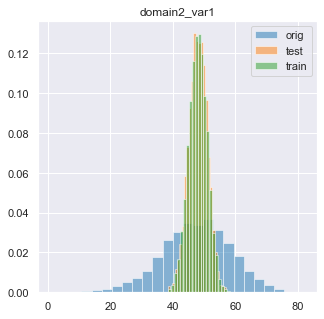

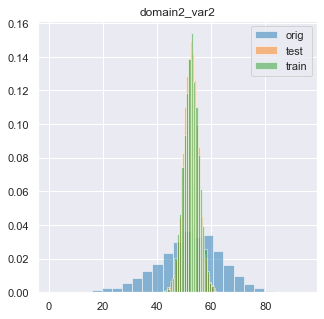

Score: 0.1571 | -0.1439 -0.1501 -0.1477 -0.1800 -0.1734


In [20]:
datasets_to_check = ['short_merge']

for dataset_id in datasets_to_check:

    predictions = {}
    scores = []
    grids = []

    for tidx, target in enumerate(['age', 'domain1_var1', 'domain1_var2', 'domain2_var1', 'domain2_var2']):

        print('Starting with dataset %s - target: %s' % (dataset_id, target))
        estimator = Ridge()
        df_pred, pred_tr, pred_te, grid, idx = run_prediction(model_metric,
            dataset_id=dataset_id, target=target, estimator=estimator,
            scaler_targets=scaler_targets, tidx=tidx)
        
        display_grid_optimization_details(grid)

        predictions['%s_tr' % target] = pred_tr
        predictions['%s_te' % target] = pred_te
        predictions['%s_miss' % target] = idx
        
        scores.append(grid.best_score_)
        grids.append(grid)

    # Display grids summary
    grids_summary(grids)
    
    # Compute overall score
    weights = [.3, .175, .175, .175, .175]
    score = np.sum([-s * weights[i] for i, s in enumerate(scores)])
    score_postfix = [int(score*10000)] + [-int(s*10000) for i, s in enumerate(scores)]

    df_results_tr, df_results_te = save_results(
        predictions, scaler_targets, targets, test_id, feature_transform,
        sample_submission, dataset_id, score_postfix)

    plot_prediction_distributions(targets, scaler_targets, df_results_tr, df_results_te)
    
    # Feedback of overall score
    txt = 'Score: {:.4f} | {:.4f} {:.4f} {:.4f} {:.4f} {:.4f}'.format(score, *scores)
    print(txt)